
<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center"> Cats vs Dogs </h2>
    <h2 align="center" style="color:#01ff84"> Loading your dataset</h2>
<div>

<br>
    
So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src="imgs/dog.png" width="200" height="40" />
<img src="imgs/cat.png" width="200" height="40" />
    

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.
    
<br>
    
Start importing the needed libraries:
    


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import time

import torch

from torch import device
from torch import optim
from torchvision import datasets, transforms


The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). They are already splitted into a training set and test set.

 
>**Exercise:** Download the dataset and place the train and test set in the `datasets/cat_vs_dog` folder. If you're cloning this from github, you should have it in `../datasets/`. So first create the `cat_vs_dog` folder in `datasets` and verify that the data are there by running `ls ../datasets/cat_vs_dog` (or your custom path if you changed it).

In [2]:
!ls ../../../../Datasets/cat_vs_dog/



test  train


Great! Now that you have downloaded your data, you need to define the transformations to be passed to the `ImageFolder` function. You have already used them with the MNIST dataset (see the Data Augmentation workbook in Pytorch). While for MNIST you were passing the transformation in the following line of code

`datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)`

here you do it in the `ImageFolder` method. You can think it as a way to work on every dataset, not only on the MNIST one.


### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. 

As in the other notebook, you can use the following transformations:

```python
transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

```

**WARNING!** Remember that transformation are super useful for "augmenting" your training data, so that you make your network less vulnerable to different sizes, rotations, or cropping. However, when you are on the test data, there is no need of augmenting the data! Actually, it is not a good practice to do that because there would be very repetitive test data that invalidates your score.

For this reason, define two different transformations for training and test data (remember that `ToTensor()` and normalization are necessary also for the test data, as well as the resizing (you can use `transforms.Resize(size)` for it):



In [3]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(200),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([transforms.Resize((200, 200)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])


data_dir = "../../../../Datasets/cat_vs_dog" # or the path where you have downloaded the dataset

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transform)

Now that you have you have defined the needed transformation, it's time to build the Data loader itself!

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Build the dataloader for both the train and test data. Choose the batch size that fits your memory. 
**Remember** NOT TO shuffle the test data! 

In [4]:
trainloader =  torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)
trainloader

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Run this to test your data loaders
# images, labels = next(iter(trainloader))
# imshow(images[0], normalize=False)



Ok, now let's create a simple Convolutional Neural Network for this task!

**N.B.** When building a convolutional neural network, be careful for making all the shapes to match (with Pytorch, in Keras is handled automatically).


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 16, 5)
        self.fc1 = nn.Linear(16*47*47, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


net = Net()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.NLLLoss()




Why do we reshape in the middle of the forward pass?

As you remember from the class, the output of a convolutional layer is always a 3D volume! For this reason, since the output channels of the conv2 layer is 16 and the feature maps have size 5x5, then the input of the fc1 layer must be reshaped to have shape `(batch_size, 16 * 5 * 5)`.

Now the question is: what will be the difference in the training of this network with respect to the fully-connected one you are used to?

None, except for the fact that you do not reshape the input to be a vector, but you keep the shape as a volume! 

>**Exercise:** Implement a Convolutional Neural Network for the cat vs dog challenge, such that:
> - The input images have shape 28x28 and three RGB channels
> - You have 2 Conv2d layer with MaxPool2D in the middle and two fully-connected layer at the end.
> - You can decide yourself the rest of the hyperparameters (kernel size, number of filters...)
> - Train and evaluate your model

Following there's an helper function to visualize your prediction once your model has been built.



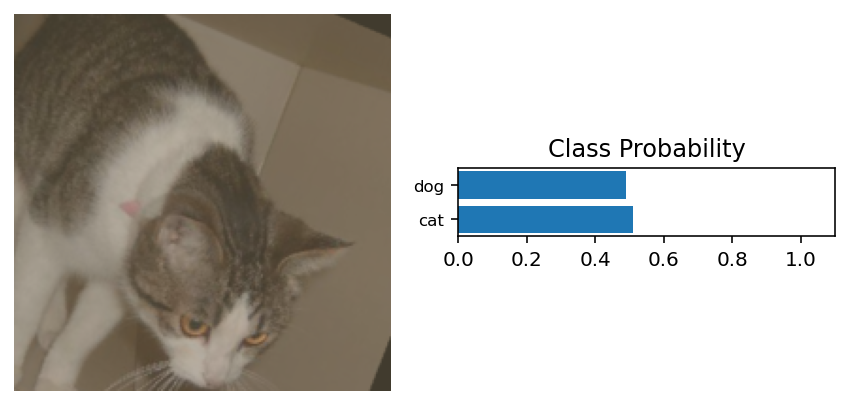

In [7]:
import numpy as np
class_list = train_data.classes

def view_classify_general(img, ps, class_list):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img, ax=ax1, normalize=True)
    ax1.axis('off')
    ax2.barh(np.arange(len(class_list)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(class_list)))
    ax2.set_yticklabels([x for x in class_list], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

images, labels = next(iter(trainloader))
img, label = images[0], labels[0]
# Flatten images
# Forward pass, get our logits
logits = net(img.view(1, *images[0].shape))
# Calculate the loss with the logits and the labels
ps = torch.exp(logits)
    
view_classify_general(img, ps, class_list)

You should get something cute like this:

![image](imgs/cat_pred.png)


In [8]:
train_transf = transforms.Compose([ #transforms.Resize((250, 250)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(250),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

test_transf = transforms.Compose([transforms.Resize((250, 250)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])


data_dir = "../../../../Datasets/cat_vs_dog" # or the path where you have downloaded the dataset

train_set = datasets.ImageFolder(data_dir + '/train', transform=train_transf)
test_set = datasets.ImageFolder(data_dir + '/test', transform=test_transf)

In [9]:
trainloader_ex =  torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
testloader_ex  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
trainloader_ex

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Exercise_net(nn.Module):
    def __init__(self):
        super(Exercise_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 5, padding=2, stride=2)
        self.fc1 = nn.Linear(32*15*15, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        # x = F.softmax(x, dim=1)
        return x

In [11]:
model = Exercise_net()

In [12]:
if torch.cuda.is_available():
    model.cuda()

<ipython-input-13-6a49feb7198f>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(logits)


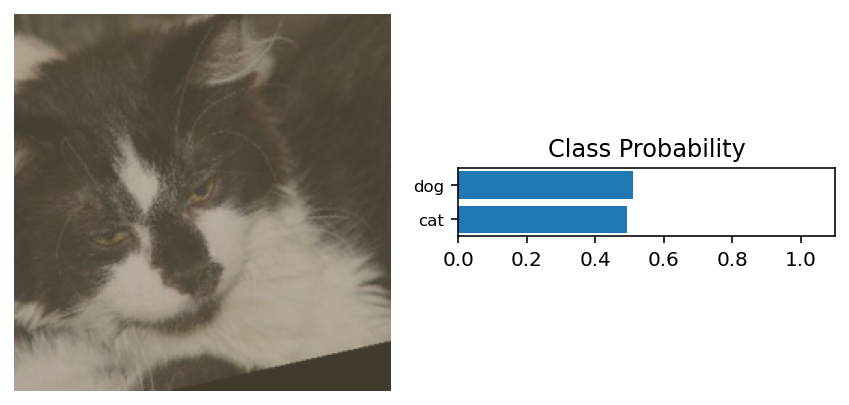

In [13]:
class_list = train_set.classes

images, labels = next(iter(trainloader_ex))
img, label = images[0], labels[0]

if torch.cuda.is_available():
    img = img.cuda()
    label = label.cuda()
# Flatten images
# Forward pass, get our logits
logits = model(img.view(1, *images[0].shape))
logits = logits.cpu()
# Calculate the loss with the logits and the labels
# ps = F.softmax(torch.exp(logits), dim=1)
# ps = torch.exp(logits)
ps = F.softmax(logits)
img = img.cpu()
    
view_classify_general(img, ps, class_list)

In [14]:
img.size()

torch.Size([3, 250, 250])

In [18]:
# First step: defining criterion and optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.NLLLoss()


# first step for testing pourposes

print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader_ex))
if torch.cuda.is_available:
    images, labels = images.cuda(), labels.cuda()
# images.resize_(trainloader_ex.batch_size, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[ 2.3939e-03, -4.2200e-04, -2.8137e-03,  ..., -4.0669e-03,
          8.5793e-03,  5.2610e-03],
        [-2.3626e-03, -1.3781e-03, -8.8106e-03,  ...,  3.7856e-03,
          1.4392e-03, -2.3618e-03],
        [-5.9782e-03, -9.7199e-05, -1.9254e-03,  ...,  1.0847e-02,
         -7.3315e-03,  9.9590e-03],
        ...,
        [ 1.1368e-02,  6.9348e-03,  5.3002e-03,  ...,  3.6532e-03,
         -4.3824e-03, -1.1159e-02],
        [-3.5801e-04,  9.3665e-03, -1.1325e-02,  ...,  8.9026e-03,
          7.6054e-03,  3.2690e-03],
        [ 3.1518e-04,  2.3237e-04,  3.0398e-03,  ...,  1.4590e-03,
          8.5457e-03,  5.2155e-04]], device='cuda:0', requires_grad=True)
Gradient - tensor([[-3.0315e-05, -2.8028e-05, -1.6984e-05,  ..., -2.3516e-05,
         -2.7774e-06, -1.0454e-05],
        [ 1.2306e-04,  7.5284e-05,  7.0964e-05,  ...,  3.7480e-05,
          4.4317e-05,  9.0170e-05],
        [-1.2160e-05, -1.1424e-05, -1.6999e-05,  ...,  4.0728e-05,
      

In [19]:
def check_accuracy(test_loader, model):
    acc_list = []
    y_preds_list = []
    y_true_list = []
    for i, (images_test, y_true) in enumerate(iter(test_loader)):
        y_preds = []

        # if torch.cuda.is_available():
            # images_test = images_test.cuda()
            # y_true = y_true.cuda()
        model.cpu()
        # Flatten EMNIST images into a 784 long vector
        # images_test.resize_(images_test.size()[0], 784)
        logits = model.forward(images_test)
        # output_preds = F.softmax(logits, dim=1)
        output_preds = logits
        # output_preds.cpu()
        for p in output_preds:
            y_preds.append(p.argmax())
        
        # y_preds.cpu()
        y_preds = np.array(y_preds)
        y_preds = torch.tensor(y_preds)

        for i in range(y_preds.size(0)):
            y_preds_list.append(y_preds[i].item())
            y_true_list.append(y_true[i].item())

    accuracy = (np.array(y_preds_list) == np.array(y_true_list)).sum()/len(y_preds_list)
    print(accuracy)

    return accuracy, y_preds_list, y_true_list

In [20]:
epochs = 10
print_every = 40
accs_test = []
start = time.time()

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader_ex)):

        # Flatten EMNIST images into a 784 long vector
        # images.resize_(images.size()[0], 784)
        if torch.cuda.is_available():

            images = images.cuda()
            labels = labels.cuda()
            model.cuda()
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        # print(output, output.shape)
        loss = criterion(output, labels) # 2) Compute loss
        # print(loss)
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
    model.eval()
    with torch.no_grad():

        acc, y_pred, y_true = check_accuracy(testloader_ex, model)
        accs_test.append(acc)
    model.train()

print('It took {} s to train', time.time() - start)

Epoch: 1/10
	Iteration: 0	 Loss: 0.0174
	Iteration: 40	 Loss: 0.6934
	Iteration: 80	 Loss: 0.6930
	Iteration: 120	 Loss: 0.6922
	Iteration: 160	 Loss: 0.6932
	Iteration: 200	 Loss: 0.6920
	Iteration: 240	 Loss: 0.6920
	Iteration: 280	 Loss: 0.6912
	Iteration: 320	 Loss: 0.6912
	Iteration: 360	 Loss: 0.6913
	Iteration: 400	 Loss: 0.6900
	Iteration: 440	 Loss: 0.6888
	Iteration: 480	 Loss: 0.6890
	Iteration: 520	 Loss: 0.6859
	Iteration: 560	 Loss: 0.6859
	Iteration: 600	 Loss: 0.6860
	Iteration: 640	 Loss: 0.6874
	Iteration: 680	 Loss: 0.6832
0.5736
Epoch: 2/10
	Iteration: 0	 Loss: 0.0162
	Iteration: 40	 Loss: 0.6843
	Iteration: 80	 Loss: 0.6781
	Iteration: 120	 Loss: 0.6804
	Iteration: 160	 Loss: 0.6797
	Iteration: 200	 Loss: 0.6754
	Iteration: 240	 Loss: 0.6830
	Iteration: 280	 Loss: 0.6761
	Iteration: 320	 Loss: 0.6804
	Iteration: 360	 Loss: 0.6685
	Iteration: 400	 Loss: 0.6772
	Iteration: 440	 Loss: 0.6655
	Iteration: 480	 Loss: 0.6780
	Iteration: 520	 Loss: 0.6634
	Iteration: 560	 

In [41]:
from PIL import Image
img = Image.open("imgs/catsven.png")

In [42]:
img = img.convert('RGB')


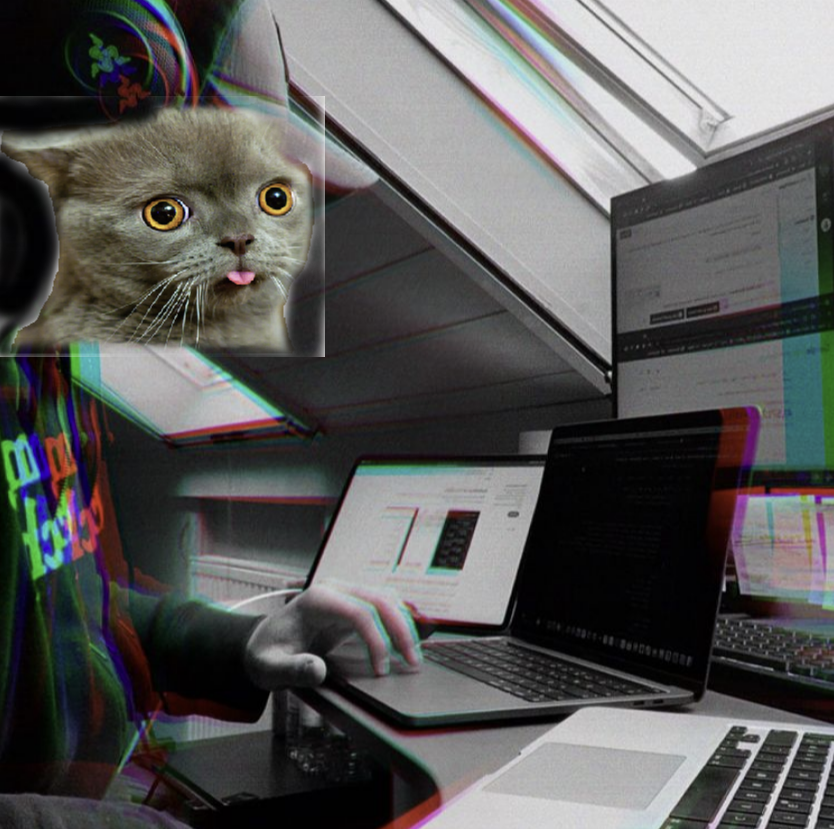

In [43]:
img

In [44]:
trans = transforms.ToTensor()
img = trans(img)

In [45]:
img.resize_(1, 3, 250, 250)

tensor([[[[0.0235, 0.0235, 0.0235,  ..., 0.5020, 0.5216, 0.5098],
          [0.5333, 0.5373, 0.5451,  ..., 0.6980, 0.6275, 0.5373],
          [0.4431, 0.4549, 0.4627,  ..., 0.8941, 0.8980, 0.8980],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.6392, 0.6392, 0.6078],
          [0.4941, 0.2902, 0.2667,  ..., 0.6549, 0.6510, 0.6353],
          [0.6196, 0.6039, 0.5725,  ..., 0.8941, 0.8902, 0.8863]],

         [[0.8863, 0.8902, 0.8941,  ..., 0.2431, 0.1255, 0.0588],
          [0.0549, 0.0471, 0.0314,  ..., 0.5686, 0.5608, 0.5569],
          [0.5333, 0.4941, 0.4588,  ..., 0.8863, 0.8902, 0.8941],
          ...,
          [0.1804, 0.1882, 0.2000,  ..., 0.4510, 0.4941, 0.5059],
          [0.4863, 0.4784, 0.5020,  ..., 0.6902, 0.6902, 0.6980],
          [0.7020, 0.7020, 0.6941,  ..., 0.5686, 0.5843, 0.5961]],

         [[0.5961, 0.5961, 0.5882,  ..., 0.4824, 0.4471, 0.4157],
          [0.4039, 0.3961, 0.4314,  ..., 0.7333, 0.7176, 0.7020],
          [0.6941, 0.6902, 0.6902,  ..., 0

In [26]:
model.cpu()

logits = model(img.view(1, *images[0].shape))

In [30]:
ps = torch.exp(logits)

In [31]:
img.size()

torch.Size([1, 3, 250, 250])

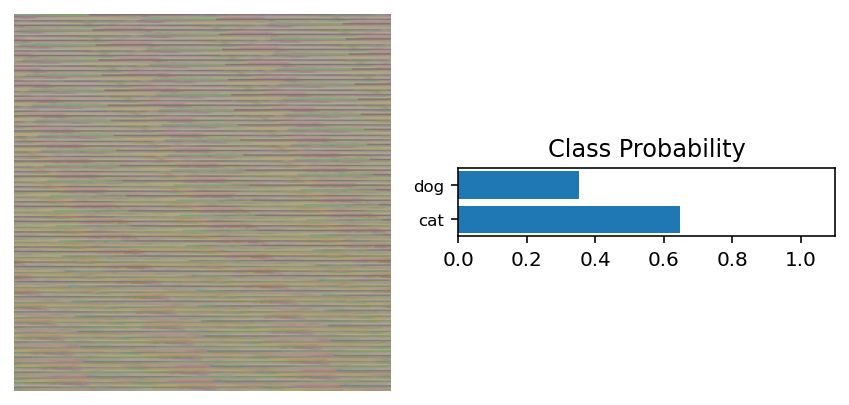

In [32]:

view_classify_general(img[0], ps, class_list)

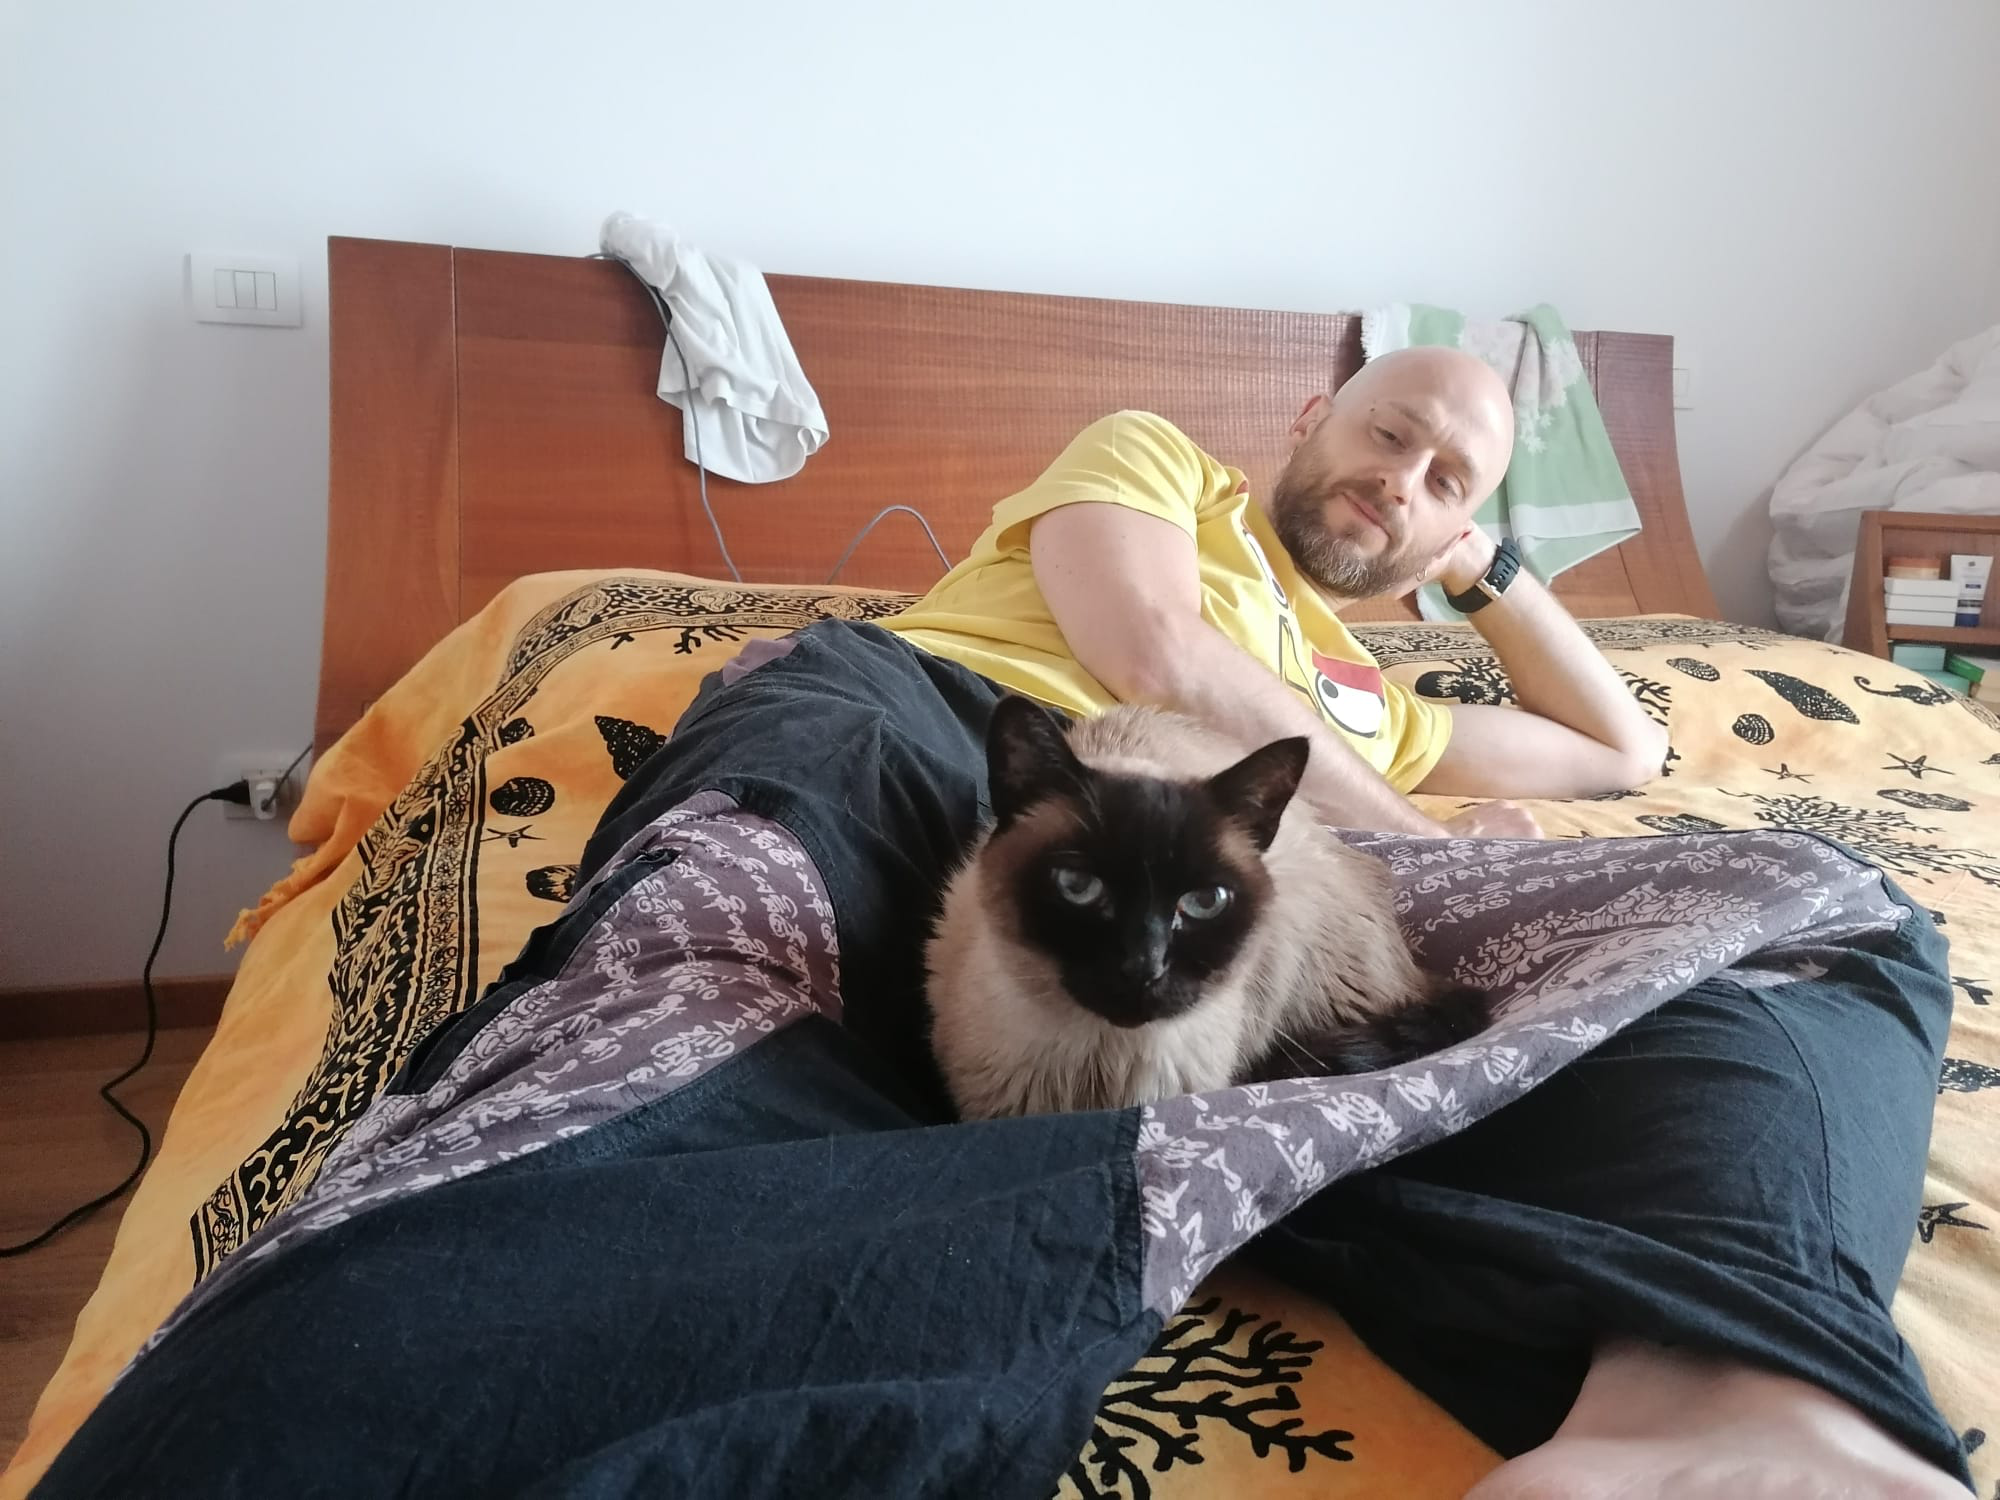

In [55]:
img_2 = Image.open('../../../../../Pictures/Ponyo/Brici.jpeg')
img_2 = img_2.convert('RGB')

img_2

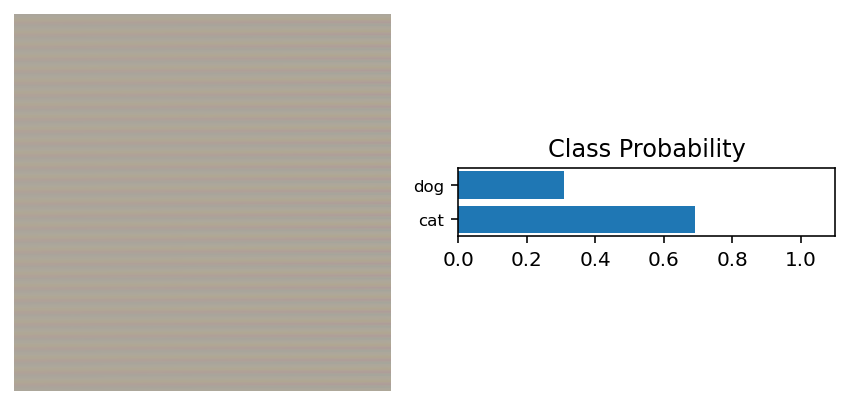

In [56]:
img_2 = trans(img_2)
img_2.resize_(1, 3, 250, 250)
logits_2 = model(img_2.view(1, *images[0].shape))
ps_2 = torch.exp(logits_2)
view_classify_general(img_2[0], ps_2, class_list)